# Error correction with cat qubits

A central obstacle to building useful quantum computers is the prevalence of hardware-level noise, which corrupts quantum information long before meaningful computations can be completed. Quantum error correction addresses this challenge by encoding a single logical qubit across many noisy physical qubits, allowing errors to be detected and corrected without destroying the encoded information.

Dissipative cat qubits encode one logical qubit in the phase space of a quantum harmonic oscillator, also known as a bosonic mode. As the average photon number increases, the phase-flip error rate of a cat qubit can be suppressed exponentially, while the bit-flip error rate grows only linearly [[REF](https://arxiv.org/pdf/1907.11729)]. This asymmetry enables access to regimes of strong noise bias, where phase-flip errors can, in principle, be made arbitrarily rare, leaving bit-flip errors as the dominant remaining failure mode.

This noise bias can be exploited by concatenating cat qubits with higher-level quantum error-correcting codes that are optimized to suppress bit-flip errors. The result is a substantial reduction in the number of physical resources required to achieve fault-tolerant quantum computation, compared to architectures based on unbiased qubits.

In this challenge, you will explore how cat qubits enable significant reductions in hardware overhead for fault-tolerant quantum computing. You will also investigate novel error-correcting codes that are particularly well suited for concatenation with cat qubits, further reducing complexity and resource requirements.

**NOTE:** All subtasks in this notebook are marked with `[TODO]`. You can use Ctrl/Cmd+F to find them and make sure you do not miss any. In some places, you will also see sections labeled `# SOLUTION ===`, which indicate where you should add code to complete the task.

**Run this notebook from the terminal** so it uses the project venv (see **README.md** in this folder). Run the next cell to verify you're in the venv.

# 1 - Installations


Begin by uncommenting and running the cell below to install the dependencies needed for this challenge.

In [2]:
# Section 1 — Installations (or: pip install -r requirements.txt from 2026-Alice-and-Bob/)
!pip install stim~=1.15
!pip install numpy~=1.0  # 1.0 instead of 2.0 for pymatching compatibility later
!pip install scipy
!pip install pymatching~=2.0
!pip install sinter~=1.14

In [3]:
import stim
import pymatching
import sinter
from typing import List
import matplotlib.pyplot as plt
import os 
import numpy as np


print(stim.__version__)

1.15.0


# 2 - Bell states & Error Detection Codes

The following section demonstrates the creation and measurement of a bell state:

$$ \frac{|00\rangle + |11\rangle}{\sqrt{2}}$$

Then, we will use bell states as codewords for the smallest error detection code.

In [4]:
circuit = stim.Circuit()

# First, the circuit will initialize a Bell pair.
circuit.append("H", [0])
circuit.append("CNOT", [0, 1])

# Then, the circuit will measure both qubits of the Bell pair in the Z basis.
circuit.append("M", [0, 1])

In [6]:
print(circuit)
print("")
print(circuit.diagram())
print("")
# circuit.diagram('timeline-svg')

H 0
CX 0 1
M 0 1

q0: -H-@-M:rec[0]-
       |
q1: ---X-M:rec[1]-



Now, we can sample this circuit and, in doing so, measure the state of each qubit.

In [7]:
sampler = circuit.compile_sampler()
sampler.sample(shots=10)

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       [False, False],
       [ True,  True],
       [False, False],
       [ True,  True],
       [False, False],
       [False, False],
       [False, False]])

Here, False means 0 and True means 1. Notice how the results of the measurement qubit 0 and the measurement on qubit 1 always match, as expected of a bell state. So, we can expect a parity measurement between the two qubits to always be 0, since the two qubits will always have the same state. In stim, the parity is measured using a "DETECTOR" operation, as shown below:

In [8]:
circuit.append("DETECTOR", [stim.target_rec(-1), stim.target_rec(-2)])
print(repr(circuit))

stim.Circuit('''
    H 0
    CX 0 1
    M 0 1
    DETECTOR rec[-1] rec[-2]
''')


In [9]:
sampler = circuit.compile_detector_sampler()
print(sampler.sample(shots=5))

[[False]
 [False]
 [False]
 [False]
 [False]]


Now, let's add X errors onto each qubit.

In [11]:
p = 0.2
circuit = stim.Circuit(f"""
    H 0
    CX 0 1
    
    TICK
    X_ERROR({p}) 0 1
    TICK

    M 0 1
    DETECTOR rec[-1] rec[-2]
""")

# circuit.diagram('timeline-svg')

In [13]:
sampler = circuit.compile_detector_sampler()
print(sampler.sample(shots=10))

[[False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [False]]


With stim, we can quickly collect many samples, extracting the detector hit rate, which should be:

$$p*(1-p)*2$$

In [14]:
import numpy as np
print(np.sum(sampler.sample(shots=10**6)) / 10**6)
print(p*(1-p)*2)

0.319715
0.32000000000000006


## Task 2.1: Error detection code

[TODO, 10pts]: As shown, in the absence of noise the parity between the two qubits in a Bell state is fixed.

The presence of a single-qubit bit-flip error changes this parity, which appears as a nonzero detector outcome when the stabilizer $Z_0 Z_1$ is measured. This observation can be used to construct the simplest quantum error-detecting code, the two-qubit code $[[2,1,1]]$. In the notation $[[n,k,d]]$, $n$ is the number of physical qubits, $k$ is the number of logical qubits, and $d$ is the code distance. The distance $d$ is the minimum weight of a Pauli operator that preserves the codespace while acting nontrivially on the logical information.

You will now implement a $[[2,1,1]]$ code using two data qubits and one ancilla qubit to measure the stabilizer $Z_0 Z_1$. A convenient choice of logical basis states within the codespace is

$$
\ket{0_L} = \ket{\Phi^+} = \frac{\ket{00} + \ket{11}}{\sqrt{2}}, \qquad
\ket{1_L} = \ket{\Phi^-} = \frac{\ket{00} - \ket{11}}{\sqrt{2}}.
$$

Assume that each data qubit undergoes an independent $X$ error with probability $p = 0.1$. An odd number of bit flips anticommutes with $Z_0 Z_1$ and is therefore detected by the parity check. By postselecting on runs with a trivial detector outcome (i.e. detector = False), all such odd-parity leakage error events are removed. These are denoted leakage errors, as they the qubits out of the codespace, spanned by superpositions of the codewords. 


As a result, postselection suppresses all first-order physical bit-flip errors. The only remaining error process on the accepted runs is the even-parity event $X_0 X_1$, which is a logical identity operator as both codewords are in its +1 eigenbasis. 

Set up this code, simulate it with X errors on each data qubit after the preparation of a bell state, and show that leakage errors and logical errors are fully suppressed with postselection on no detector events. Calculate the success probability of no detector errors occurring as a function of the physical error rate $p$ and show that it matches your simulation.

In [21]:
# SOLUTION ===
# [[2,1,1]] code: 2 data qubits, Bell state = |0_L>, stabilizer Z_0 Z_1 via ancilla qubit measurement
circuit = stim.Circuit()

# Standard EPR pair creation circuit
circuit.append("H", [0])
circuit.append("CNOT", [0, 1])

# Add bit-flip error to both data qubits
p = 0.1
circuit.append("X_ERROR", [0, 1], [p])

# Entangle data qubits with ancilla to perform Z_0Z_1 stabilizer measurement
circuit.append("CNOT", [0, 2])   # data0 → ancilla
circuit.append("CNOT", [1, 2])   # data0 → ancilla

# Computational basis reset on the ancilla qubit 
# (same as post-selecting on 0 outcome, since it adds automatic X correction if outcome is 1)
circuit.append("M", [2])

# Measure data qubits in computational basis
circuit.append("M", [0])
circuit.append("M", [1])
# ===

In [19]:
# circuit.diagram('timeline-svg')

In [22]:
# SOLUTION ===
n_shots = 50000
sampler = circuit.compile_sampler()
circuit_output = sampler.sample(shots=n_shots) # IMPORTANT: entries are ordered in how measurements are ordered in 

# Post-select on parity check passing
post_selected_output = circuit_output[circuit_output[:,0] == False]  
num_discarded = circuit_output[circuit_output[:,0] == True].shape[0]
# Logical error: we prepare |0_L>. Accepted runs have 0 or 2 X errors (X_0 X_1 = logical I).
# So accepted runs always have correct logical state -> logical error rate = 0.
simulated_logical_error_rate = post_selected_output[post_selected_output[:,0] == True].shape[0] / post_selected_output.shape[0]

# Amount of runs where the parity check fails
drop_rate = num_discarded/n_shots
# ===

Simulated success probability (no detector): 0.818900
Simulated logical error rate (postselected): 0.0


In [27]:
p = 0.1
success_prob = 1 - p*(1-p)*2
simulated_success_prob = (n_shots - num_discarded) / n_shots
print(f"Simulated success probability: {simulated_success_prob:.6f}")
print(f"Analytical success probability: {success_prob:.6f}")
print(f"Simulated logical error rate (postselected): {simulated_logical_error_rate}")
# print("success probability:", success_prob, simulated_logical_error_rate)

Simulated success probability: 0.818900
Analytical success probability: 0.820000
Simulated logical error rate (postselected): 0.0


# 3 - Repetition Code

## Task 3.1 Implement a decoder for the repetition code.

[TODO, 5pts]: You will now implement and simulate the $n$-qubit repetition code with asymmetric distance $[[n,1,d_X=n,d_Z=1]]$, defined by the logical codewords

$$
\ket{0_L} = \ket{000\cdots 0}, \qquad 
\ket{1_L} = \ket{111\cdots 1}.
$$

The stabilizer group is generated by the $n-1$ nearest-neighbor parity checks

$$
Z_i Z_{i+1}, \qquad i = 0, \dots, n-2 .
$$

These stabilizers extract $n-1$ independent bits of syndrome information, leaving exactly one protected logical degree of freedom. In other words, the code encodes a single logical qubit into $n$ physical qubits. A convenient choice of logical operators is

$$
X_L = X_0 X_1 \cdots X_{n-1}, \qquad Z_L = Z_0 \ \ (\text{equivalently any } Z_i),
$$

so the code has $X$-distance $d_X=n$ (it protects against bit-flip errors up to weight $\lfloor (n-1)/2\rfloor$) but only $Z$-distance $d_Z=1$.

Your first task is to implement a decoder that takes as input a final measurement of all data qubits together with a single round of stabilizer measurements, and outputs the most likely logical state. Rather than using a simple majority-vote rule, your decoder should explicitly use the stabilizer syndromes to infer a most likely correction consistent with the observed syndrome, apply that correction to the final data-qubit measurements, and then determine the decoded logical value. This approach is more scalable to real-time quantum error correction, where stabilizer measurements can be used to decode errors and apply corrections during an algorithm to recover back to the codespace and protect logical information.

*Note: For codes used with biased physical noise, it is often useful to specify separate distances $d_X$ (the minimum weight nontrivial logical $X$ operator) and $d_Z$ (the minimum weight nontrivial logical $Z$ operator), rather than quoting a single distance $d=\min(d_X,d_Z)$.


In [31]:
from typing import Tuple

def decode_repetition_code(
    meas: Tuple[str, str],
) -> int:

    """
    Decode an n-qubit classical repetition code (bit-flip code).

    Args:
        meas: (data_bits, stabilizer_bits)
            - data_bits: length-n string like "001" (final Z-basis measurements of data qubits)
            - stabilizer_bits: length-(n-1) string like "01" (parity checks between neighbors),
              typically s_i = data_bits[i] XOR data_bits[i+1], ordered left-to-right.
              This input is accepted but not required for majority decoding.

    Returns:
        0 or 1: decoded logical state.
    """

    # SOLUTION ===
    # Simple propagation decoder, on every 1 in the syndrome, flip the data bit w.r.t. previous one.
    # Start with initial data bit guess and flip based on lowest Hamming weight
    syndrome_string = np.array(list(meas[1]), dtype=int)
    data_string = np.array(list(meas[0]), dtype=int)
    d = np.array([0]*len(meas[0]))
    for i,s in enumerate(syndrome_string):
        d[i+1] = d[i] ^ s
    d_flipped = d ^ 1

    d_weight = np.sum(d)
    d_flipped_weight = np.sum(d_flipped)

    # Choose correction vector with lowest Hamming weight
    correction_vector = d if d_weight <= d_flipped_weight else d_flipped
    return np.bincount(np.mod(data_string + correction_vector, 2)).argmax()
    # ===


# Example:
print(decode_repetition_code(("00001", "0001")))  # -> 0
print(decode_repetition_code(("00011", "0011")))  # -> 0
print(decode_repetition_code(("01011", "1110")))  # -> 1 (additional check)
print(decode_repetition_code(("11111", "0000")))  # -> 1 (no syndrome, codeword 11..1)

0
0
1
1


## Task 3.2 - Simulate logical error rates

[TODO, 5pts]: Now, set up stim circuits to prepare logical $\ket{0_L}$ or $\ket{1_L}$. This circuit should contain $n$ data qubits and $n-1$ measure qubits that are used to measure parity between neighboring data qubits. Then, insert X errors on the data qubits with probability $p$ after initializing qubits to logical $\ket{0_L}$ or $\ket{1_L}$, measure the parity stabilizers $Z_{i}Z_{i+1}$ with measure qubits, and finally measure the state of each data qubit. 

Then, using your decoder, decode what the logical state should be for each possible scenario. The ratio of when you decoded incorrectly over the total number of shots is your logical error probability $p_L$. 

Make a plot of $p_L$ vs physical error probability (sampled logarithmically) $p \in [0.1, 0.5]$ for $n \in [3,5,7,9]$. Both axes in this plot should be on a log scale. At what value of $p$ do you see a threshold, the point where increasing $n$ helps to suppress logical errors? 

In [79]:
# e.g. 3-qubit rep code

circuit = stim.Circuit('''
    R 0 1 2 3 4

    TICK
    X_ERROR(0.1) 0 2 4

    TICK
    CX 0 1 2 3
    
    TICK
    CX 2 1 4 3
    
    TICK
    MR 1 3
    
    DETECTOR(1, 0) rec[-2]
    DETECTOR(3, 0) rec[-1]

    TICK
    M 0 2 4
    OBSERVABLE_INCLUDE(0) rec[-3]
    OBSERVABLE_INCLUDE(1) rec[-2]
    OBSERVABLE_INCLUDE(2) rec[-1]
''')

In [80]:
# generalized rep code

def repetition_code_circuit(n: int, p: float = 0.1, prepare_logical: int = 0) -> stim.Circuit:
    """
    Build an n-qubit repetition code circuit using a Stim string.

    Layout:
      data qubits:   0, 2, 4, ..., 2(n-1)
      ancilla qubits:1, 3, 5, ..., 2(n-2)+1

    Total qubits: 2n-1
    """
    all_string = " ".join(str(k) for k in range(0, 2*n-1))
    cx_1 = " ".join(str(k) for k in range(0, 2*n-2))
    cx_2 = " ".join(str(k) for k in reversed(range(1, 2*n-1)))
    even_string = " ".join(str(k) for k in range(0, 2*n - 1, 2))
    uneven_string = " ".join(str(k) for k in range(1, 2*n - 1, 2))

    detector_string = ""
    c = len(range(1, 2*n - 1, 2))
    for i in range(1, 2*n - 1, 2):
        detector_string += f"DETECTOR({i}, 0) rec[-{c}]\n"
        c-=1

    observable_string = ""
    c = len(range(0, 2*n - 1, 2))
    for i in range(0, 2*n - 1, 2):
        observable_string += f"OBSERVABLE_INCLUDE({i/2}) rec[-{c}]\n"
        c-=1

    if prepare_logical:
        logical_bit_string = f"X {even_string}"
    else:
        logical_bit_string = ""

    circuit = stim.Circuit(f'''
        R {all_string}
        {logical_bit_string}
    
        TICK
        X_ERROR({p}) {even_string}
    
        TICK
        CX {cx_1}
        
        TICK
        CX {cx_2}
        
        TICK
        MR {uneven_string}
        
        {detector_string}
        TICK
        M {even_string}
        {observable_string}
    ''')
    return circuit


def simulate_circuit(circuit, n, num_shots=100_000):
    """ 
    Simulate the circuit and return the results.

    Args:
        circuit: The circuit to simulate.
        n: The number of data qubits.

    Returns:
        results: {(data_bits, stabilizer_bits): counts}
    """
    sampler = circuit.compile_sampler()
    samples = sampler.sample(shots=num_shots)
    results = {}
    for row in samples:
        stabilizer_bits = "".join(str(int(b)) for b in row[: n - 1])
        data_bits = "".join(str(int(b)) for b in row[n - 1 : 2 * n - 1])
        key = (data_bits, stabilizer_bits)
        results[key] = results.get(key, 0) + 1
    return results


def logical_error_rate(
    results: dict[tuple[str, str], int],
    logical_prepared: int = 0,
) -> float:
    """
    Compute logical error rate using decode_repetition_code.

    Args:
        results: {(data_bits, stabilizer_bits): counts}
        logical_prepared: 0 or 1 logical state that was prepared.

    Returns:
        Logical error probability.
    """

    # SOLUTION ===
    
    total = sum(results.values())
    errors = 0
    for (data_bits, stabilizer_bits), count in results.items():
        decoded = decode_repetition_code((data_bits, stabilizer_bits))
        if decoded != logical_prepared:
            errors += count
    return errors / total if total else 0.0
    # ===


def run_sim(n, p):
    circuit = repetition_code_circuit(n, p=p)
    results = simulate_circuit(circuit, n)
    return logical_error_rate(results, logical_prepared=0)

In [81]:
# Example
n = 3
p = 0.1
prepare_logical = 0
circuit = repetition_code_circuit(n, p=p, prepare_logical=prepare_logical)

In [82]:
# circuit.diagram('timeline-svg')

In [77]:
results = simulate_circuit(circuit, n)
# results

In [83]:
pL_sim = logical_error_rate(results, logical_prepared=prepare_logical)
print("Logical error rate (simulated):", pL_sim)

prob_two_error = 3 * (1-p) * p * p
prob_three_error = p * p * p
sim_logical_error_rate = prob_two_error + prob_three_error
print("Logical error rate (analytical, 2 or 3 X errors):", round(sim_logical_error_rate,4))

# Verification: Check that relative deviation is less than 5%
rel_err = abs(pL_sim - sim_logical_error_rate) / (sim_logical_error_rate or 1e-10)
if rel_err < 0.05: 
    print("OK: simulated and analytical match.")
else:
    print("Simulation deviated more that 5% from theoretical reference")

Logical error rate (simulated): 0.02828
Logical error rate (analytical, 2 or 3 X errors): 0.028
OK: simulated and analytical match.


In [51]:
error_probabilities = np.logspace(-1, np.log10(0.5), 21)
distances = [3, 5, 7, 9]

# SOLUTION ===
# collect simulation data for varying distances and error_probabilities
data_plot = {}  # n -> (p_list, pL_list)
for n in distances:
    p_list, pL_list = [], []
    for p in error_probabilities:
        pL = run_sim(n, p)
        p_list.append(p)
        pL_list.append(pL)
    data_plot[n] = (p_list, pL_list)
# ===

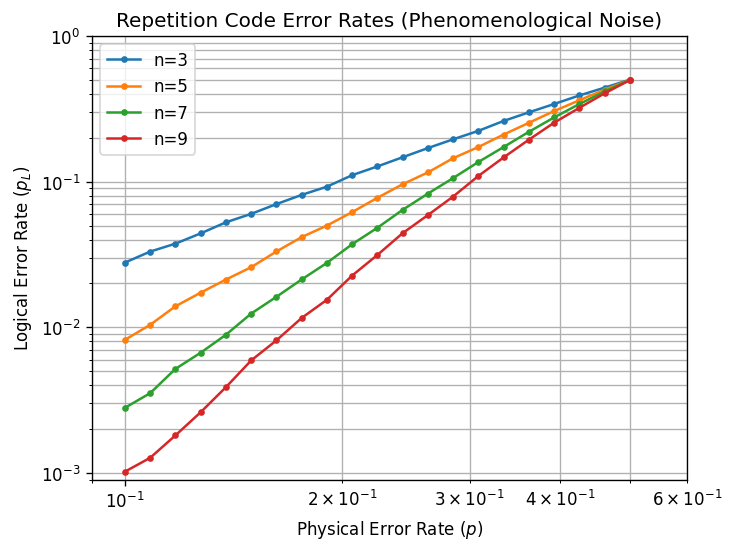

In [102]:
# SOLUTION ===
# plot results
fig, ax = plt.subplots(1, 1)
for n in distances:
    p_list, pL_list = data_plot[n]
    ax.loglog(p_list, pL_list, "o-", label=f"n={n}", markersize=3)
ax.set_ylim(9e-4, 1e-0)
ax.set_xlim(9e-2, 6e-1)
ax.loglog()
ax.set_title("Repetition Code Error Rates (Phenomenological Noise)")
ax.set_xlabel("Physical Error Rate ($p$)")
ax.set_ylabel("Logical Error Rate ($p_L$)")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger
# # Threshold: below ~0.17 increasing n reduces p_L; above it, larger n can increase p_L.
# ===

# 4 - Compare surface code vs cat-repetition code

In this section, we will benchmark the cat-repetition code against a conventional surface code built from unbiased qubits. While the surface code is designed to protect against general, symmetric noise, the cat-repetition code is optimized for a strongly biased error channel in which phase flips are exponentially suppressed and bit flips dominate. By comparing these two architectures under their respective noise models, we can directly evaluate the advantages of exploiting hardware bias. We will focus on resource efficiency, logical error rates, and scaling with system size to highlight when and why a bias-tailored code can outperform a more general-purpose quantum error correcting code.

Here is an especially useful resource for this section: 
[https://github.com/quantumlib/Stim/blob/main/doc/getting_started.ipynb](https://github.com/quantumlib/Stim/blob/main/doc/getting_started.ipynb)

Please feel free to adapt code from the above notebook. The point of the tasks in this section is to explore logical error rates and hardware resource overheads in different parameter regimes, not figure out syntax.

## Task 4.1 - cat-repetition code threshold

Since cat qubits can exponentially suppress phase-flip errors, the dominant remaining noise channel is bit flips on the encoded qubits. In this task, you will study how the logical error rate scales with the number of cat qubits used as data qubits in a repetition code, assuming each data qubit experiences a fixed bit-flip error rate.

[TODO, 2.5pts]: First, complete `generate_rep_code_bit_flips` to return a repetition-code memory circuit with distance `d`, `3d` rounds, and bit-flip noise applied as `X_ERROR(noise)` on the data qubits. You may use Stim’s built-in repetition-code memory generator rather than implementing the circuit from scratch.

In [103]:
def generate_rep_code_bit_flips(d, noise):
    # SOLUTION ===
    circuit = stim.Circuit.generated("repetition_code:memory", rounds=3 * d, distance=d)
    data_qubits = list(range(0, 2 * d, 2)) # data qubits in Stim repetition-code layout (same convention as before)
    out = stim.Circuit()
    first_tick_done = False
    for i in range(len(circuit)):
        inst = circuit[i]
        # Add errors to every repeated block
        if isinstance(inst, stim.CircuitRepeatBlock):
            body = stim.Circuit()
            body.append_operation("X_ERROR", data_qubits, noise)
            body += inst.body_copy()
            out.append_operation(stim.CircuitRepeatBlock(inst.repeat_count, body))
        else:
            # Add errors once on the initialization
            if inst.name == "TICK" and not first_tick_done:
                out.append_operation("X_ERROR", data_qubits, noise)
                first_tick_done = True
            out.append_operation(inst)
    circuit = out
    # ===
    return circuit

We can then use this repetition code generation function to once again extract a threshold.

In [113]:
tasks = [
    sinter.Task(
        circuit=generate_rep_code_bit_flips(d, noise),
        json_metadata={'d': d, 'p': noise},
    )
    for d in [3, 5, 7, 9, 11, 13, 15]
    for noise in [0.05, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5]
]

collected_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=4,
    tasks=tasks,
    decoders=['pymatching'],
    max_shots=100_000,
    max_errors=500,
)

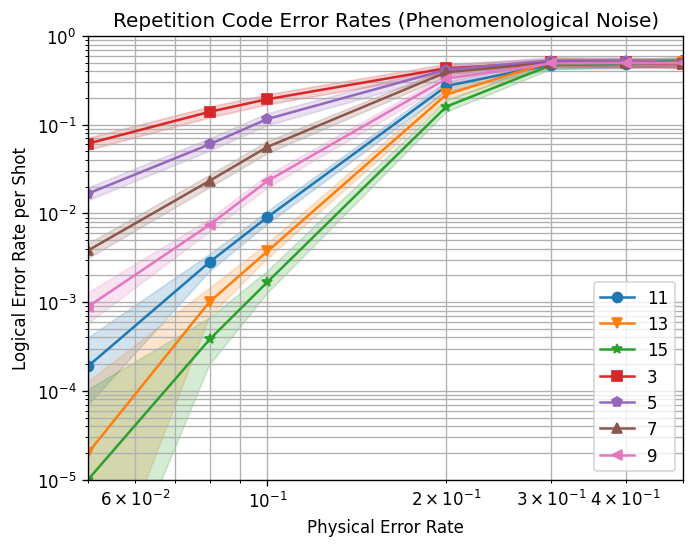

In [118]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
)
ax.set_ylim(1e-5, 1e-0)
ax.set_xlim(5e-2, 5e-1)
ax.loglog()
ax.set_title("Repetition Code Error Rates (Phenomenological Noise)")
ax.set_xlabel("Physical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

[TODO, 2.5pts]: Next, fix the physical bit-flip probability to $p_X = 0.01$. Assuming a cat-qubit noise bias of $10^8$, the corresponding phase-flip probability is $p_Z = 10^{-10}$. How many cat qubits are required in a repetition code to suppress the logical bit-flip probability below $10^{-10}$, so that it is comparable to the phase-flip level?

These parameter choices are loosely inspired by the following references, which provide a more detailed and rigorous analysis of error correction with cat qubits:
- [https://arxiv.org/abs/2302.06639](https://arxiv.org/abs/2302.06639)
- [https://arxiv.org/abs/2401.09541](https://arxiv.org/abs/2401.09541) 

Make a plot of logical error rate versus code distance $d$ for fixed $p_X = 0.01$. Note that the code distance $d$ is equal to the number of data qubits $n$ for the repetition code. Use `generate_rep_code_bit_flips`, which injects only bit flips, since phase flips are negligible in this regime.


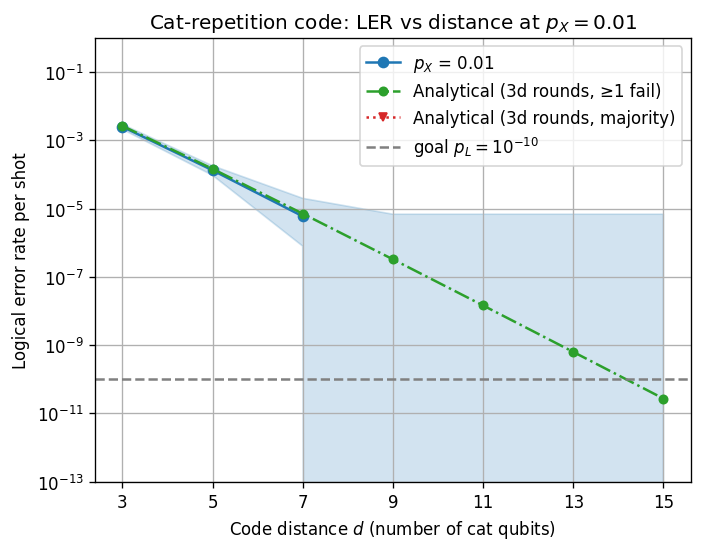

Cat qubits (distance d) required for logical error rate < 1e-10: d = 9
  (0 errors in 1000000 shots at d=9; run more shots to confirm true LER < 1e-10.)


In [125]:
bit_flip_prob = 0.01
noise_bias = 1e8
goal_logical_error_rate = bit_flip_prob/noise_bias


# SOLUTION ===
tasks_fixed_p = [
    sinter.Task(
        circuit=generate_rep_code_bit_flips(d, bit_flip_prob),
        json_metadata={'d': d, 'p': bit_flip_prob},
    )
    for d in [3, 5, 7, 9, 11, 13, 15]
]
cat_rep_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=4,
    tasks=tasks_fixed_p,
    decoders=['pymatching'],
    max_shots=1_000_000,
    max_errors=500,
)
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=cat_rep_stats,
    x_func=lambda stats: stats.json_metadata['d'],
    group_func=lambda stats: f"$p_X$ = {stats.json_metadata['p']}",
)


# --- Theoretical comparison (rigorous) ---
# (1) Single-round: P1(d,p) = P(majority of d data qubits flip in one round). Exact for one round + majority decode.
# (2) Simulation uses pymatching (global MWPM on full syndrome graph), so there is no closed-form LER; curves below are simplified models.
# (3) Multi-round "at least one": P_L = 1 - (1-P1)^(3d) = P(at least one of 3d rounds fails under per-round majority). Heuristic upper-bound style.
# (4) Multi-round "majority of rounds": P_L = sum_{k>=ceil((3d+1)/2)} C(3d,k) P1^k (1-P1)^(3d-k). Exact for 3d independent round outcomes (each wrong w.p. P1) then majority vote. Not what pymatching does.
from scipy.special import comb
def logical_error_rate_rep_code_theory(n, p):
    t = n // 2 + 1  # min errors causing logical failure (majority wrong)
    return sum(comb(n, k) * p**k * (1 - p)**(n - k) for k in range(t, n + 1))
def logical_error_rate_3d_rounds_at_least_one(d, p):
    P1 = logical_error_rate_rep_code_theory(d, p)
    return 1 - (1 - P1)**(3 * d)
def logical_error_rate_3d_rounds_majority(d, p):
    P1 = logical_error_rate_rep_code_theory(d, p)
    T = 3 * d
    t_maj = (T + 1) // 2  # majority of 3d round outcomes wrong
    return sum(comb(T, k) * P1**k * (1 - P1)**(T - k) for k in range(t_maj, T + 1))
distances = [3, 5, 7, 9, 11, 13, 15]
#y_theory = [logical_error_rate_rep_code_theory(d, bit_flip_prob) for d in distances]
#ax.plot(distances, y_theory, 's--', markersize=5, label='Analytical (single round)', color='C1')
y_theory_multi = [logical_error_rate_3d_rounds_at_least_one(d, bit_flip_prob) for d in distances]
ax.plot(distances, y_theory_multi, 'o-.', markersize=5, label='Analytical (3d rounds, ≥1 fail)', color='C2')
y_theory_maj = [logical_error_rate_3d_rounds_majority(d, bit_flip_prob) for d in distances]
ax.plot(distances, y_theory_maj, 'v:', markersize=5, label='Analytical (3d rounds, majority)', color='C3')
ax.axhline(goal_logical_error_rate, color='gray', linestyle='--', label=f'goal $p_L = 10^{{-10}}$')


# Simulation (MWPM) LER lies between single-round and multi-round heuristics; ylim to 1e-13 so theory at d=15 is visible
ax.set_ylim(1e-13, 1e-0)
ax.set_xticks(distances)
ax.set_xticklabels([str(d) for d in distances])
ax.set_xlabel('Code distance $d$ (number of cat qubits)')
ax.set_ylabel('Logical error rate per shot')
ax.set_title('Cat-repetition code: LER vs distance at $p_X = 0.01$')
ax.set_yscale('log')
ax.grid(which='major')
ax.grid(which='minor')
handles, labels = ax.get_legend_handles_labels()
import re
def _sort_key(item):
    m = re.search(r'\d+', item[0])
    return int(m.group()) if m else 999
by_d = sorted(zip(labels, handles), key=_sort_key)
labels_sorted, handles_sorted = [l for l, h in by_d], [h for l, h in by_d]
ax.legend(handles_sorted, labels_sorted)
fig.set_dpi(120)
plt.show()
d_required = None
stat_at_goal = None
for s in sorted(cat_rep_stats, key=lambda s: s.json_metadata['d']):
    pL = s.errors / s.shots if s.shots else 1.0
    if pL < goal_logical_error_rate:
        d_required = s.json_metadata['d']
        stat_at_goal = s
        break
if d_required is not None:
    print(f'Cat qubits (distance d) required for logical error rate < {goal_logical_error_rate:.0e}: d = {d_required}')
    if stat_at_goal.errors == 0:
        print(f'  (0 errors in {stat_at_goal.shots} shots at d={d_required}; run more shots to confirm true LER < 1e-10.)')
else:
    print(f'Within the d range simulated, LER did not drop below {goal_logical_error_rate:.0e}; try larger d or more shots.')
# ===

## 4.2 - surface code benchmarks

The surface code can be viewed as a two-dimensional generalization of the repetition code that protects against both bit-flip and phase-flip errors. For this reason, many groups are pursuing surface-code architectures built from unbiased qubits (such as transmons) to suppress both types of logical errors simultaneously.

Next, we will generate an analogous plot of logical error rate versus the number of data qubits for a fixed physical depolarizing error probability of 0.001 using the surface code. From this, we will estimate how many qubits are required to reach a logical error rate of ($10^{-10}$), enabling a direct comparison with the cat-repetition results.


### 4.2.1 - surface code threshold

[TODO, 2.5pts]: First, complete `generate_surface_code_depolraizing_noise` to return a surface-code memory circuit with distance `d`, `3d` rounds, and depolarizing noise applied on data qubits. You may use Stim’s built-in surface-code memory generator and flags rather than implementing the circuit from scratch.

In [126]:
def generate_surface_code_depolarizing_noise(d, noise):
    # SOLUTION ===
    # Task: surface-code memory with distance d, 3d rounds, depolarizing noise on data qubits.
    # Logical-qubit system: physical error rate p = noise.
    # - before_round_data_depolarization(p): DEPOLARIZE1(p) on each data qubit at round start.
    # - after_clifford_depolarization(p): DEPOLARIZE1(p)/DEPOLARIZE2(p) after each Clifford gate.
    p = float(noise)
    circuit = stim.Circuit.generated(
        "surface_code:rotated_memory_z",
        rounds=3 * d,
        distance=d,
        before_round_data_depolarization=p,
        after_clifford_depolarization=p,
    )
    # ===
    return circuit

Then, we can use stim tooling to find the threshold for the surface code.

In [127]:
import os
import sinter
from typing import List

surface_code_tasks = [
    sinter.Task(
        circuit = generate_surface_code_depolarizing_noise(d, noise),
        json_metadata={'d': d, 'r': d * 3, 'p': noise},
    )
    for d in [3, 5, 7]
    for noise in [0.008, 0.009, 0.01, 0.011, 0.012]
]

collected_surface_code_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=os.cpu_count(),
    tasks=surface_code_tasks,
    decoders=['pymatching'],
    max_shots=1_000_000,
    max_errors=5_000,
    print_progress=False,
)

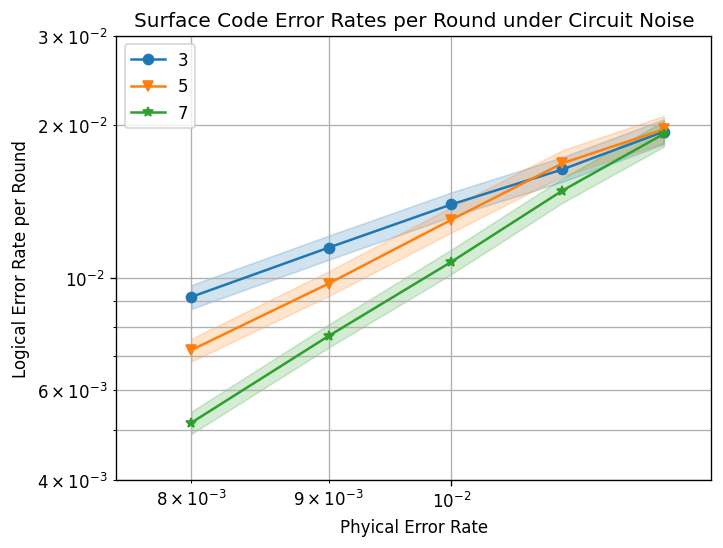

In [139]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_surface_code_stats,
    x_func=lambda stat: stat.json_metadata['p'],
    group_func=lambda stat: stat.json_metadata['d'],
    failure_units_per_shot_func=lambda stat: stat.json_metadata['r'],
)
ax.set_ylim(4e-3, 3e-2)
ax.set_xlim(0.0075, 0.0125)
ax.loglog()
ax.set_title("Surface Code Error Rates per Round under Circuit Noise")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which='major')
ax.grid(which='minor')
handles, labels = ax.get_legend_handles_labels()
import re
def _sort_key(item):
    m = re.search(r'\d+', item[0])
    return int(m.group()) if m else 999
by_d = sorted(zip(labels, handles), key=_sort_key)
labels_sorted, handles_sorted = [l for l, h in by_d], [h for l, h in by_d]
ax.legend(handles_sorted, labels_sorted)
fig.set_dpi(120)  # Show it bigger

### 4.2.2 - estimate # of qubits for fault-tolerance

[TODO, 2.0pts]: Next, fix the depolarizing noise probability to $p = 0.001$, inspired by SOTA performance in transmon-based surface codes. As we did for the cat-repetition code, make a plot of logical error rate versus code distance $d$, which is equal to $\sqrt{n}$ for the square surface code, where $n$ is the number of data qubits. Use your `generate_surface_code_depolarizing_noise` function. The lower ylim of your plot should be `goal_logical_error_rate`. 

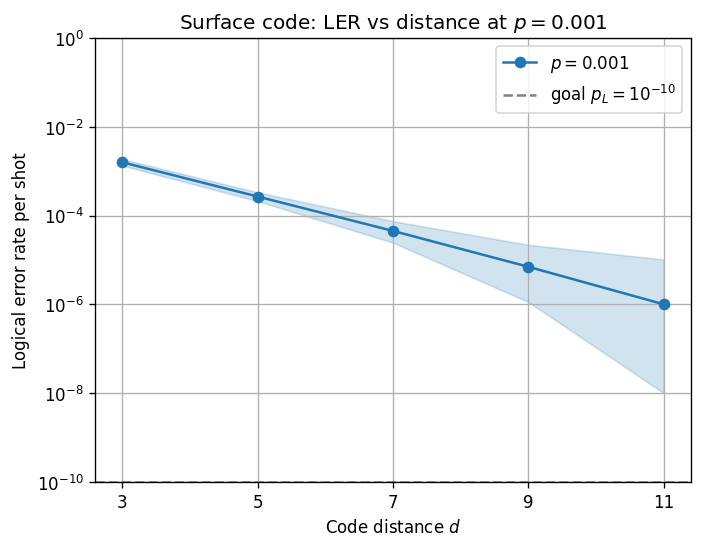

In [141]:
noise = 1e-3
goal_logical_error_rate = 1e-10

# SOLUTION ===
# Fixed p = 0.001, vary d; plot LER per shot vs d (like cat-repetition code).
surface_code_distances = [3, 5, 7, 9, 11]
surface_code_tasks_fixed_p = [
    sinter.Task(
        circuit=generate_surface_code_depolarizing_noise(d, noise),
        json_metadata={'d': d, 'p': noise},
    )
    for d in surface_code_distances
]
surface_code_stats_fixed_p: List[sinter.TaskStats] = sinter.collect(
    num_workers=4,
    tasks=surface_code_tasks_fixed_p,
    decoders=['pymatching'],
    max_shots=1_000_000,
    max_errors=500,
)

fig, ax = plt.subplots(1, 1)
# LER per shot (no failure_units_per_shot_func) for fair comparison with cat-rep
sinter.plot_error_rate(
    ax=ax,
    stats=surface_code_stats_fixed_p,
    x_func=lambda stat: stat.json_metadata['d'],
    group_func=lambda stat: f"$p = {stat.json_metadata['p']}$",
)
ax.axhline(goal_logical_error_rate, color='gray', linestyle='--', label=f'goal $p_L = 10^{{-10}}$')
ax.set_ylim(goal_logical_error_rate, 1e-0)
ax.set_xticks(surface_code_distances)
ax.set_xticklabels([str(d) for d in surface_code_distances])
ax.set_yscale('log')
ax.set_xlabel('Code distance $d$')
ax.set_ylabel('Logical error rate per shot')
ax.set_title('Surface code: LER vs distance at $p = 0.001$')
ax.grid(which='major')
ax.grid(which='minor')
handles, labels = ax.get_legend_handles_labels()
import re
def _sort_key(item):
    m = re.search(r'\d+', item[0])
    return int(m.group()) if m else 999
by_d = sorted(zip(labels, handles), key=_sort_key)
labels_sorted, handles_sorted = [l for l, h in by_d], [h for l, h in by_d]
ax.legend(handles_sorted, labels_sorted)
fig.set_dpi(120)
plt.show()
# ===

[TODO, 0.5pts]: Finally, compare the performance of the cat-repetition code to the surface code. In particular, comment on the resource requirements and potential challenges of both approaches.

**Resource requirements.** Surface codes are designed for unbiased noise: they correct both X (bit-flip) and Z (phase-flip) errors and require on the order of $d^2$ physical qubits per logical qubit for code distance $d$. Cat qubits, by contrast, exhibit strongly biased noise: phase-flip errors are exponentially suppressed with the mean photon number, while bit-flip errors remain the dominant failure mode. When a surface code is used on top of cat qubits, roughly half of its resources are devoted to correcting phase flips that are already negligible at the physical level. That redundancy does not improve logical performance and is therefore inefficient. The cat-repetition (bit-flip) code corrects only X errors and uses $O(d)$ physical qubits per logical qubit. It is matched to the error structure of cat qubits, so all code overhead targets the dominant error type. For a given target logical error rate under biased noise, the repetition-code approach is thus significantly more resource-efficient in terms of physical qubits and syndrome measurements.

**Challenges.** Repetition codes only correct one type of flip error; they are suitable only when phase errors are negligible (as for well-tuned cat qubits). If phase-flip rates are non-negligible, a repetition code alone is insufficient and a concatenated or hybrid strategy may be needed. Surface codes, meanwhile, incur higher connectivity and gate-count overhead and require decoding of both X and Z syndromes, which adds complexity. In summary: for cat qubits with strong bias, the cat-repetition code offers better resource scaling and simpler decoding by specializing to bit-flip correction; the surface code remains a general-purpose option but pays for correcting errors that are already suppressed at the hardware level.
